In [106]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
import time
import torch.nn as nn

In [107]:
NB_EPOCH = 100
TIME_LIM = None # 25
BATCH_SIZE = 64


REPEAT_TIMES = 10

In [108]:
def make_2d_classification(N=4000, well_split=True):
    a_pos1 = torch.randn(N//4, 2) + torch.tensor([3.0, 2.0])
    a_pos2 = torch.randn(N//4, 2) + torch.tensor([-3.0, 3.0])
    if well_split:
        a_neg = torch.randn(N//2, 2) + torch.tensor([-2.0, -5.0])
    else:
        a_neg = torch.randn(N//2, 2) + torch.tensor([-2.0, -2.0])
    data = torch.cat([a_pos1, a_pos2, a_neg], dim=0)
    data = (data - data.mean(axis=0)) / np.sqrt(data.var(axis=0))
    labels = torch.cat([torch.ones(N//2), torch.zeros(N//2)])
    return TensorDataset(data, labels)

In [109]:
# from https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torchvision
import torchvision.transforms as transforms

trainset = torchvision.datasets.MNIST(root='./data', 
                                      train=True,
                                      download=True, 
                                      #transform=transform
                                      )

testset = torchvision.datasets.MNIST(root='./data', 
                                     train=False,
                                     download=True,
                                     #transform=transform
                                     )

In [110]:
from torch.utils.data import TensorDataset
from sklearn.preprocessing import StandardScaler

def filter_classes_MNIST(dataset, classes_to_keep):

    # Get data and targets
    data = dataset.data.flatten(start_dim=1)
    targets = dataset.targets

    # Create mask
    mask = (targets == classes_to_keep[0]) | (targets == classes_to_keep[1])

    # Apply mask
    # filtered_data = (data[mask] / 255).float()
    
    scaler = StandardScaler()
    filtered_data = torch.from_numpy(scaler.fit_transform(data[mask])).float()

    # filtered_data = (filtered_data - filtered_data.mean(axis=0)) / np.sqrt(filtered_data.var(axis=0))

    label_map = {classes_to_keep[0]: 0, classes_to_keep[1]: 1}
    filtered_targets = torch.tensor([label_map[t.item()] for t in targets[mask]])

    return TensorDataset(filtered_data, filtered_targets)

In [111]:
mnist_01_train = filter_classes_MNIST(trainset, [0,1])
# mnist_01_test = filter_classes_MNIST(testset, [0,1])

In [112]:
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 2))
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

In [113]:
# check https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/
# check https://github.com/shaoanlu/dogs-vs-cats-redux/blob/master/opt_experiment.ipynb

In [114]:
from sklearn.datasets import make_blobs

# torch.manual_seed(42)
# np.random.seed(42)

DATASET_SIZE = 1000
DATASET_DIM = 20
DATASET_CLUSTER_COUNT = 5

def blob_dataset():
    clustered_data, _ = make_blobs(n_samples=DATASET_SIZE, 
                                n_features=DATASET_DIM,
                                centers=DATASET_CLUSTER_COUNT,
                                #random_state=42
                                )

    data = torch.from_numpy(clustered_data.astype(np.float32))
    labels = torch.zeros(DATASET_SIZE)
    return TensorDataset(data, labels)

In [115]:
from cluster_tools import kmeans_elbow_aux, ClusterSampler, logistic_label_01_process

Samplers

In [116]:
LAMBDA = 1e-4 # L2 regularization

class SimpleModel(nn.Module):
    def __init__(self, dataset):
        super().__init__()
        assert len(dataset.shape) == 2, "Do not use with images"
        dim = dataset.shape[1]
        self.layer = nn.Linear(dim, 1, bias=True)
        self.layer.weight.data.fill_(0)
        self.layer.bias.data.fill_(0)
    
    def forward(self, ai):
        return self.layer(ai)

def log_01_criterion(pred, labels):
    l = labels.view(-1, 1)*2 - 1
    return (nn.functional.softplus(-l*pred)).mean()

In [117]:
from sklearn.datasets import load_svmlight_file
import warnings

def load_svm_classif_tensor(filename, process=None):
    X, y = load_svmlight_file(filename)
    X = torch.tensor(X.toarray(), dtype=torch.float32)

    scaler = StandardScaler()
    scaled_X = torch.from_numpy(scaler.fit_transform(X)).float()

    y = torch.tensor(y, dtype=torch.int32)
    if process is not None: # converts the other possible label types to 0/1
        if process == "1 2":
            y -= 1
        elif process == "+-1":
            y = (y + 1)/2
        else:
            warnings.warn("process should be one of '1 2' or '+-1'", UserWarning)
    return TensorDataset(scaled_X, y)

In [118]:
dataset = mnist_01_train#load_svm_classif_tensor("./data/phishing_dataset.txt") #make_2d_classification(well_split=True) 
clustered_data, full_labels = dataset.tensors
labeled_data = logistic_label_01_process(dataset)
N = len(dataset)

In [119]:
# probably utils function
from utils import dimension_reduction

compressed_data = dimension_reduction(clustered_data, alg="pca")

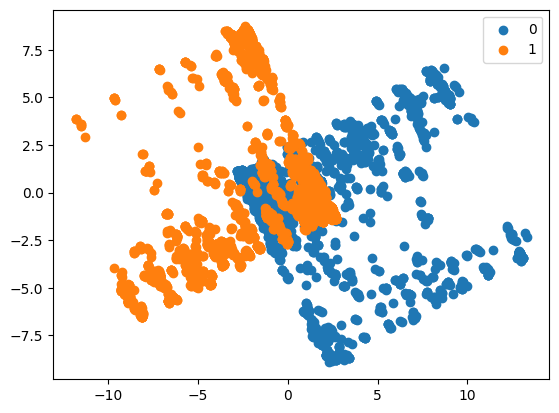

In [34]:
compressed_labeled = dimension_reduction(labeled_data, alg="pca")
mask_0 = (full_labels == 0)
mask_1 = (full_labels == 1)
plt.scatter(compressed_labeled[mask_0,0], compressed_labeled[mask_0,1], label="0")
plt.scatter(compressed_labeled[mask_1,0], compressed_labeled[mask_1,1], label="1")
plt.legend()
plt.show()

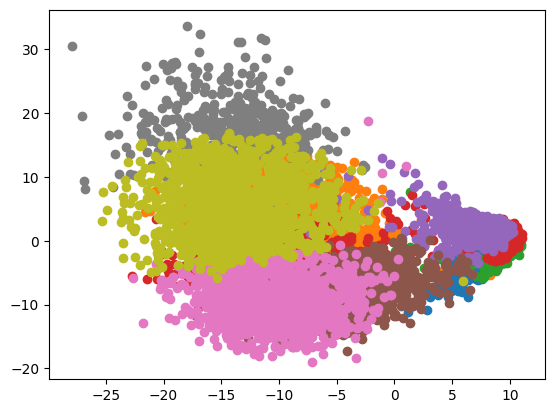

In [120]:
from cluster_tools import get_clusters

kmeans_clusters = get_clusters(dataset, logistic_label_01_process)

cluster_sampler = ClusterSampler(N, BATCH_SIZE, kmeans_clusters)
for i in range(cluster_sampler.cluster_count):
    selected = compressed_data[cluster_sampler.clusters[i]]
    try:
        plt.scatter(selected[:,0], selected[:,1])
    except:
        print(selected)
# plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], color="white", alpha=0.1)
plt.show()

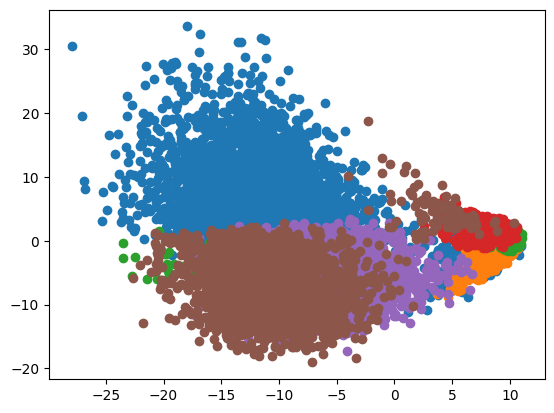

In [121]:
from cluster_tools import kmeans_cos_elbow

cos_clusters = get_clusters(dataset, logistic_label_01_process, kmeans_cos_elbow)
cosine_cluster_sampler = ClusterSampler(N, BATCH_SIZE, cos_clusters)
for i in range(cosine_cluster_sampler.cluster_count):
    selected = compressed_data[cosine_cluster_sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
# plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], color="white", alpha=0.1)
plt.show()

Solvers

In [122]:
def get_grad(batch, labels, model, criterion=log_01_criterion):
    ret = np.zeros_like(batch)
    for i, (elem, lab) in enumerate(zip(batch, labels)):
        res = model(elem)
        l = criterion(res, lab)
        model.zero_grad()
        l.backward()
        ret[i] = (next(model.parameters()).grad.data.detach().numpy().squeeze())
    return ret

In [123]:
# finding an exact solution

from tqdm import tqdm
from solvers import get_regularized_loss

model = SimpleModel(clustered_data)

def train_model_until(model, err, lr=2):
    curr_epoch = 0
    regularized_ls = []

    while 1:
        reg_loss = get_regularized_loss(model, 
                                        clustered_data, 
                                        full_labels, 
                                        log_01_criterion,
                                        LAMBDA)
        model.zero_grad()
        reg_loss.backward()
        for p in model.parameters():
            p.data.sub_(lr*(p.grad.data))
        regularized_ls.append(reg_loss.item())
        curr_epoch += 1
        if curr_epoch % 1000 == 0:
            print(curr_epoch, reg_loss.item())
        if curr_epoch > 1 and regularized_ls[-2] - regularized_ls[-1] < err:
            break
    return curr_epoch, regularized_ls

curr_epoch, regularized_ls = train_model_until(model, 1e-11)
opt_val = regularized_ls[-1]
print(curr_epoch, opt_val)

1000 0.0025750466156750917
2000 0.0017532818019390106
3000 0.0012413491494953632
4000 0.0009141056216321886
5000 0.0007190221222117543
6000 0.0006169333937577903
7000 0.0005713013233616948
8000 0.0005531322676688433
9000 0.0005457170773297548
10000 0.0005423208931460977
11000 0.0005405955598689616
12000 0.0005396606284193695
13000 0.0005391343147493899
14000 0.0005388305289670825
14891 0.000538667431101203


In [124]:
output = model(clustered_data)
model.zero_grad()
loss = log_01_criterion(output, full_labels)
loss.backward()
for p in model.parameters():
    print(2*(p.grad.data + LAMBDA*p.data))

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  6.9654e-08,
          6.9654e-08,  6.9654e-08,  2.3632e-09, -7.5290e-09, -9.8842e-08,
         -1.0393e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.1874e-07,
         -1.1874e-07,  0.0000e+00,  3.0447e-08, -1.1468e-07, -1.2050e-07,
          0.0000e+00,  5.5835e-08,  8.

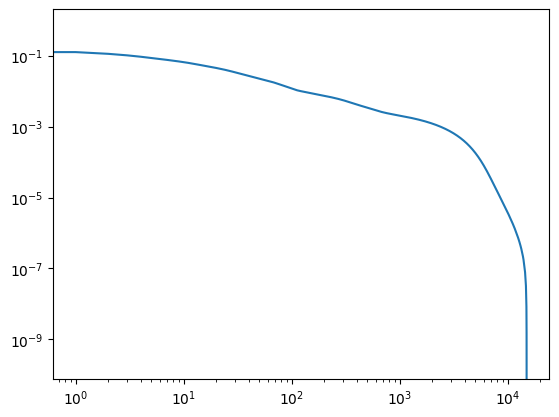

In [125]:
plt.plot(np.array(regularized_ls)-opt_val)
# plt.yscale("log")
plt.loglog()
plt.show()

Getting gradients closer to the objective, testing out if reclustering could in theory work

In [126]:
from cluster_tools import kmeans_pp_elbow

close_model = SimpleModel(clustered_data)
_ = train_model_until(close_model, 1e-4)
close_cluster_labels = kmeans_cos_elbow(get_grad(clustered_data, full_labels, close_model))
new_cluster_sampler = ClusterSampler(N, BATCH_SIZE, close_cluster_labels)

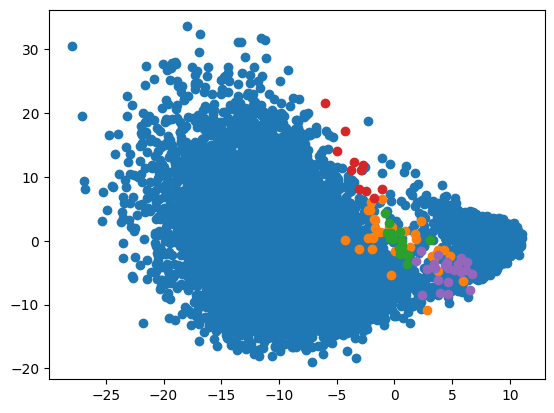

In [127]:
for i in range(new_cluster_sampler.cluster_count):
    selected = compressed_data[new_cluster_sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
# plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], color="white", alpha=0.1)
plt.show()

In [128]:
from solvers import solve_problem, svrg, COVER, clusterSVRG

In [129]:
from utils import clone_model

In [130]:
base_model = SimpleModel(clustered_data)
lr = 0.2
lr_one_t = lambda epoch: 5 / (epoch+1)
# lr_log_t = lambda epoch: 5 * np.log(epoch+1) / (epoch+1)

In [131]:
cluster_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=cluster_sampler)
cosine_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=cosine_cluster_sampler)

iid_sampler = RandomSampler(dataset, replacement=True)
iid_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=iid_sampler)

new_cluster_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=new_cluster_sampler)

Clusters from linkage clustering

In [ ]:
from cluster_tools import display_clusters, approx_nearest_clustering
from cluster_tools import alt_elbow

close_gradients = get_grad(clustered_data, full_labels, close_model)

alt_cluster_labels = alt_elbow(labeled_data.detach().numpy())
# alt_cluster_labels = approx_nearest_clustering(close_gradients)
alt_clusters = [[] for _ in range(max(alt_cluster_labels)+1)]
for i, j in enumerate(alt_cluster_labels):
    alt_clusters[j].append(i)

# display_clusters(close_gradients, alt_cluster_labels, max(alt_cluster_labels)+1)

print("nb of clusters:", len(alt_clusters))
for c in alt_clusters:
    print(len(c)/N)

In [186]:
# from solvers import alt_solve_problem

# # get number of thing per batch
# v = np.zeros(len(alt_clusters))
# for i in range(len(alt_clusters)):
#     grads = np.mean(close_gradients[alt_clusters[i]], axis=0)
#     v[i] = np.mean(np.sum((close_gradients[alt_clusters[i]] - grads)**2, axis=1))
# v = torch.from_numpy(v)

# _, alt_sol, _ = alt_solve_problem(base_model, 
#                                   log_01_criterion,
#                                   optimizer_class=torch.optim.SGD,
#                                   datasource=dataset,
#                                   cluster_labels=alt_cluster_labels,
#                                   v_i=v,
#                                   batch_size=BATCH_SIZE,
#                                   n_epoch=200)

Both for comparison and for checking if the learning rate works

In [83]:
_, sgd_sol, _ = solve_problem(
    clone_model(base_model, clustered_data), 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
    n_epoch=NB_EPOCH,
    lr=lr,
    lr_lambda=lr_one_t,
    l2=LAMBDA
)

100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


In [84]:
from solvers import full_batch_corresp

_, regular_gd_sol, _ = full_batch_corresp(
    clone_model(base_model, clustered_data),
    log_01_criterion,
    torch.optim.SGD,
    dataset,
    BATCH_SIZE,
    n_epoch=NB_EPOCH, 
    lr=lr,
    lr_lambda=lr_one_t,
    l2=LAMBDA
)

100%|██████████| 17300/17300 [00:10<00:00, 1577.99it/s]


In [85]:
opt_val = min(opt_val, min(sgd_sol))
opt_val = min(opt_val, min(regular_gd_sol))

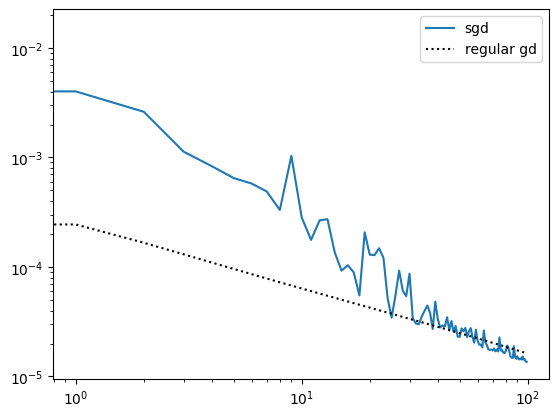

In [86]:
# plt.plot(alt_sol - opt_val, label="alt")
plt.plot(sgd_sol - opt_val, label="sgd")
plt.plot(regular_gd_sol - opt_val, linestyle='dotted', color="black", label="regular gd")

plt.loglog()
plt.legend()
plt.show()

In [132]:
def repeat_exec(base_model,
                model_arg,
                criterion,
                optimizer_class,
                dataloader,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                verbose=True,
                repeat_times=REPEAT_TIMES,
                lr=lr,
                lr_lambda=lr_one_t,
                l2=LAMBDA):
    timestamps, sols = [], []
    for i in range(repeat_times):
        sgd_time, sgd_sol, _ = solve_problem(
            clone_model(base_model, model_arg), 
            criterion,
            optimizer_class,
            dataloader,
            n_epoch,
            time_lim,
            verbose,
            lr,
            lr_lambda,
            l2)
        timestamps.append(sgd_time)
        sols.append(sgd_sol)
    return timestamps, sols

In [31]:
# sgd_times, sgd_sols = repeat_exec(
#     base_model, clustered_data, 
#     log_01_criterion,
#     optimizer_class=torch.optim.SGD,
#     dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
#     n_epoch=1000,
#     repeat_times=1
    
# )
# plt.plot(sgd_sols[0]-opt_val, color="blue", label=None)
# plt.loglog()
# plt.show()

In [ ]:
svrg_time, svrg_sol, _ = svrg(clone_model(base_model, clustered_data),
                regress_criterion,
                DataLoader(dataset, BATCH_SIZE, shuffle=True),
                clustered_data,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                learning_rate=lr,
                lr_lambda=lr_log_t)

In [ ]:
cover_time, cover_sol, _ = COVER(clone_model(base_model, clustered_data),
                     regress_criterion,
                     dataset,
                     RandomSampler(dataset),
                     clustered_data,
                     n_epoch=None,
                     time_lim=TIME_LIM,
                     learning_rate=lr,
                     lr_lambda=lr_log_t)

In [ ]:
clusterSVRG_time, clusterSVRG_sol, _ = clusterSVRG(clone_model(base_model, clustered_data),
                     regress_criterion,
                     dataset,
                     RandomSampler(dataset),
                     clustered_data,
                     n_epoch=None,
                     time_lim=TIME_LIM,
                     learning_rate=lr,
                     lr_lambda=lr_log_t)

  0%|          | 3/100000 [00:34<320:36:28, 11.54s/it]


In [ ]:
grad_des_time, grad_des_sol, _ = solve_problem(
    clone_model(base_model, clustered_data), 
    regress_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(dataset, len(clustered_data)),
    n_epoch=NB_EPOCH,
    time_lim=TIME_LIM,
    verbose=True,
    lr=lr,
    # lr_lambda=lr_log_t,
    )

Building models...


  0%|          | 158/100000 [00:30<5:18:07,  5.23it/s]


In [ ]:
svrg_single_time, svrg_single_sol, _ = svrg(clone_model(base_model, clustered_data),
                regress_criterion,
                DataLoader(dataset, shuffle=True),
                clustered_data,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                learning_rate=lr,
                lr_lambda=lr_log_t)

  0%|          | 3/100000 [00:39<363:39:27, 13.09s/it]


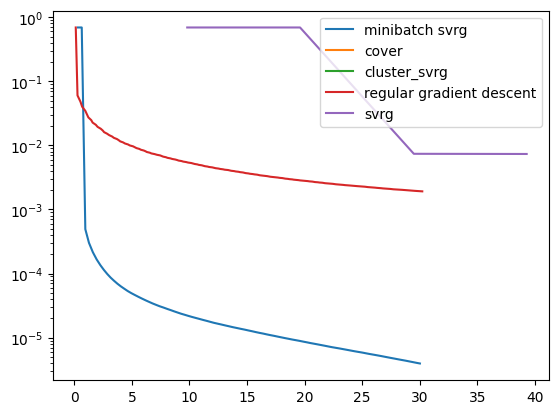

In [ ]:
plt.plot(svrg_time, svrg_sol-opt_val, label="minibatch svrg")
plt.plot(cover_time, cover_sol-opt_val, label="cover")
plt.plot(clusterSVRG_time, clusterSVRG_sol-opt_val, label="cluster_svrg")
plt.plot(grad_des_time, grad_des_sol-opt_val, label="regular gradient descent")
plt.plot(svrg_single_time, svrg_single_sol-opt_val, label="svrg")
plt.yscale("log")
plt.legend()
plt.show()

In [77]:
sgd_times, sgd_sols = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
)

Building models...


100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


In [ ]:
plt.plot(sgd_time, sgd_sol-opt_val, label="sgd")
plt.plot(adam_time, adam_sol-opt_val, label="adam")
plt.plot(svrg_time, svrg_sol-opt_val, label="svrg")
plt.plot(grad_des_time, grad_des_sol-opt_val, label="regular gradient descent")
plt.xlabel("time (s)")
plt.legend()
plt.yscale("log")
plt.show()

In [78]:
sgd_iid_times, sgd_sols_iid = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=iid_dataloader,
)

Building models...


100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


In [79]:
sgd_cluster_times, sgd_sols_cluster = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=cluster_dataloader,
)

Building models...


100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


In [80]:
sgd_cosine_times, sgd_sols_cosine = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=cosine_dataloader,
)

Building models...


100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


Building models...


100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


Building models...


100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


Building models...


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


Building models...


100%|██████████| 100/100 [00:26<00:00,  3.81it/s]


Building models...


100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


Building models...


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


Building models...


100%|██████████| 100/100 [00:25<00:00,  3.91it/s]


Building models...


100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


Building models...


100%|██████████| 100/100 [00:25<00:00,  3.86it/s]


In [137]:
# from solvers import weighted_solver
# sgd_alt_cluster_t, sgd_alt_cluster, _ = weighted_solver(
#     clone_model(base_model, clustered_data), 
#     regress_criterion,
#     torch.optim.SGD,
#     dataset,
#     n_iter=None,
#     time_lim=TIME_LIM,
#     verbose=True
# )

In [ ]:
# folder = "./saves/"
# exp_type = "MNIST_01_" #"MNIST_01_"
# bis = "(3)"
# ext = "b" + str(BATCH_SIZE) + bis + ".txt"

In [ ]:
# execution_res_names = ["sgd_sols_iid", "sgd_sols_cluster", "sgd_sols_cosine", "sgd_sols"]
# file_names = ["sgd_iid_", "sgd_clustered_", "cosine_", ""]

In [46]:
# for ref, name in zip(execution_res_names, file_names):
#     exec(ref + " = np.loadtxt(folder + exp_type + name + ext)")

In [ ]:
# for ref, name in zip(execution_res_names, file_names):
#     exec("np.savetxt('" + folder + exp_type + name + ext + "', np.array(" + ref + "))")

In [85]:
for losses in [sgd_sols_iid, sgd_sols_cluster, sgd_sols_cosine, sgd_sols]:
    for l in losses:
        opt_val = min(opt_val, min(l))
opt_val

0.000538667431101203

In [72]:
cluster1 = new_cluster_sampler.clusters[0]
restricted_data = clustered_data[cluster1]
restricted_labels = full_labels[cluster1]
wrong_model = SimpleModel(restricted_data)

regularized_ls_new = []

for i in tqdm(range(20000)):
    reg_loss = get_regularized_loss(wrong_model, 
                                    restricted_data, 
                                    restricted_labels, 
                                    log_01_criterion,
                                    LAMBDA)
    wrong_model.zero_grad()
    reg_loss.backward()
    for p in wrong_model.parameters():
        p.data.sub_(lr*(p.grad.data))
    regularized_ls_new.append(reg_loss.item())


100%|██████████| 20000/20000 [00:45<00:00, 444.05it/s]


[]

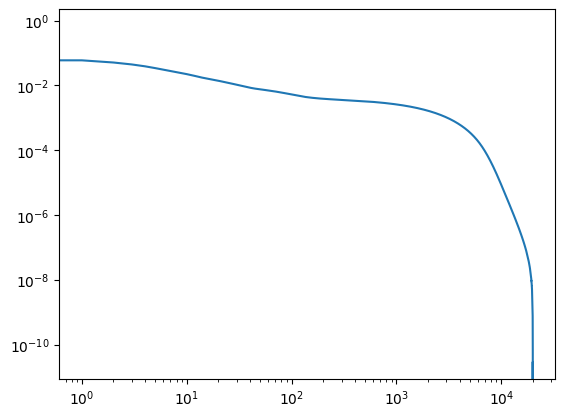

In [73]:
plt.plot(np.array(regularized_ls_new) - min(regularized_ls_new))
plt.loglog()

In [74]:
opt_wrong = get_regularized_loss(wrong_model, 
                                    clustered_data, 
                                    full_labels, 
                                    log_01_criterion,
                                    LAMBDA).item()
opt_wrong

0.003137944033369422

In [133]:
init_loss = get_regularized_loss(SimpleModel(clustered_data),
                                 clustered_data,
                                 full_labels,
                                 log_01_criterion,
                                 LAMBDA).item()
init_loss

0.6931472420692444

In [134]:
def plot_mult_iter(losses, opt_val, color, label, init_loss=init_loss):
    ls = np.array(losses)
    # because they all start at the init_loss
    # also the xscale on log removes the element 0
    ls = np.insert(ls, 0, init_loss, axis=1) 
    # for l in losses:
        # plt.plot(l-opt_val, alpha=0.3, color=color)
    m = np.mean(ls, axis=0)
    std = np.std(ls, axis=0)
    l = len(m)
    plt.plot(np.arange(1, l+1), m-opt_val, color=color, label=label, alpha=0.9)
    # plt.fill_between(np.arange(l), m-opt_val-std, m-opt_val+std, alpha=0.3)

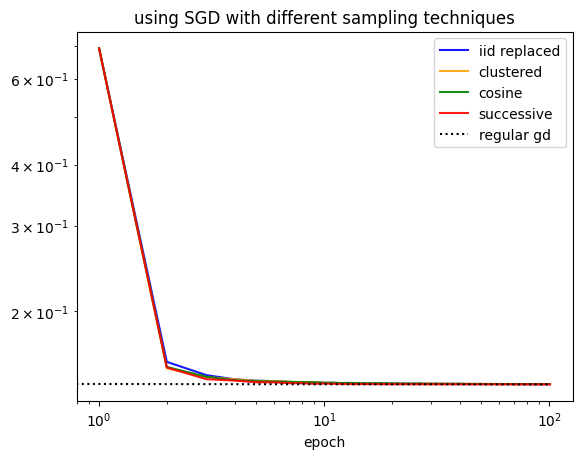

In [135]:
plot_mult_iter(sgd_sols_iid, opt_val, color="blue", label="iid replaced")
plot_mult_iter(sgd_sols_cluster, opt_val, color="orange", label="clustered")
plot_mult_iter(sgd_sols_cosine, opt_val, color="green", label="cosine")
plot_mult_iter(sgd_sols, opt_val, color="red", label="successive")
plt.plot(regular_gd_sol - opt_val, linestyle='dotted', color="black", label="regular gd")


plt.legend()
# plt.yscale("log")
plt.loglog()
plt.xlabel("epoch")
plt.title("using SGD with different sampling techniques")
plt.show()

What happens after reclustering?

In [136]:
lr_one_t_bis = lambda epoch: 5 / (epoch+1000)

In [137]:
sgd_bis_times, sgd_bis = repeat_exec(
    close_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
    lr_lambda=lr_one_t_bis,
)

Building models...


100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


Building models...


100%|██████████| 100/100 [00:22<00:00,  4.35it/s]


Building models...


100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


Building models...


100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


Building models...


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


Building models...


100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


Building models...


100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


In [138]:
sgd_iid_bis_times, sgd_iid_bis = repeat_exec(
    close_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=iid_dataloader,
    lr_lambda=lr_one_t_bis,
)

Building models...


100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.35it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


In [139]:
sgd_rec_times, sgd_rec_bis = repeat_exec(
    close_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=new_cluster_dataloader,
    lr_lambda=lr_one_t_bis,
)

Building models...


100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


Building models...


100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


Building models...


100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


Building models...


100%|██████████| 100/100 [00:28<00:00,  3.52it/s]


Building models...


100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


Building models...


100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


Building models...


100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


Building models...


100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


Building models...


100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


Building models...


100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


In [140]:
init_loss_bis = get_regularized_loss(close_model,
                                 clustered_data,
                                 full_labels,
                                 log_01_criterion,
                                 LAMBDA).item()
init_loss_bis

0.011359547264873981

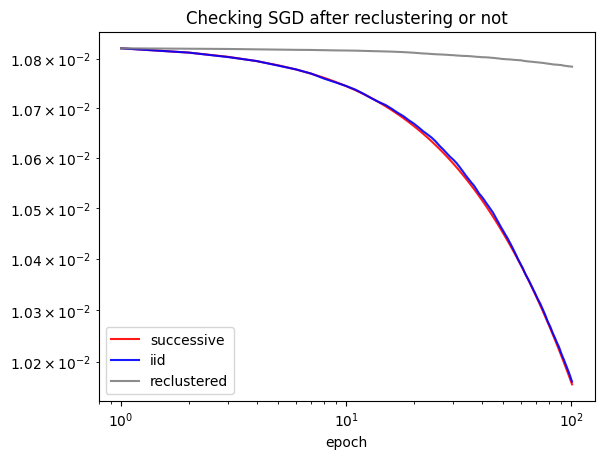

In [141]:
plot_mult_iter(sgd_bis, opt_val, color="red", label="successive", init_loss=init_loss_bis)
plot_mult_iter(sgd_iid_bis, opt_val, color="blue", label="iid", init_loss=init_loss_bis)
plot_mult_iter(sgd_rec_bis, opt_val, color="grey", label="reclustered", init_loss=init_loss_bis)

plt.legend()
# plt.yscale("log")
plt.loglog()
plt.xlabel("epoch")
plt.title("Checking SGD after reclustering or not")
plt.show()

In [52]:
from torch import Tensor

def display_grads(dataset:TensorDataset, model, cluster_sampler, alg="pca", title=""):
    n = len(dataset)
    
    dataset_torch, labels = dataset.tensors
    gradients = np.zeros_like(dataset_torch)
    lims = [0]
    for i in range(cluster_sampler.cluster_count):
        selected = dataset_torch[cluster_sampler.clusters[i]]
        selected_labels = labels[cluster_sampler.clusters[i]]
        grad_selected = get_grad(selected, selected_labels, model)
        # print(grad_selected)
        lims.append(lims[-1] + len(cluster_sampler.clusters[i]))
        gradients[lims[-2]:lims[-1], :] = grad_selected
    
    reduced = dimension_reduction(gradients, alg=alg)

    for i in range(cluster_sampler.cluster_count):
        plt.scatter(reduced[lims[i]:lims[i+1],0], 
                    reduced[lims[i]:lims[i+1],1], 
                    alpha=0.5,
                    label="cluster size {}".format(len(cluster_sampler.clusters[i])))
    plt.legend()
    plt.title(title)
    plt.show()

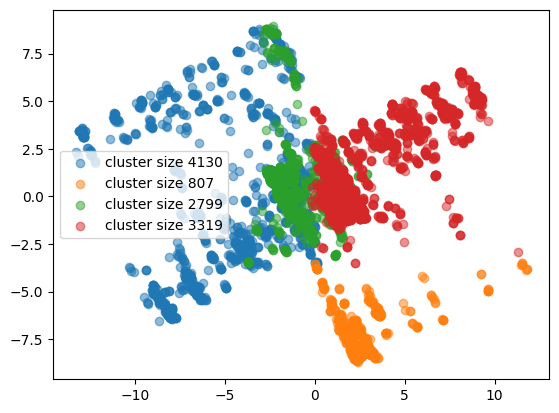

In [53]:
display_grads(dataset, SimpleModel(clustered_data), cluster_sampler)

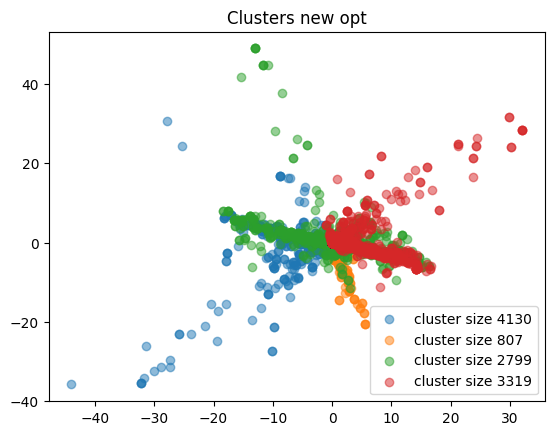

In [54]:
display_grads(dataset, model, cluster_sampler, title="Clusters new opt")

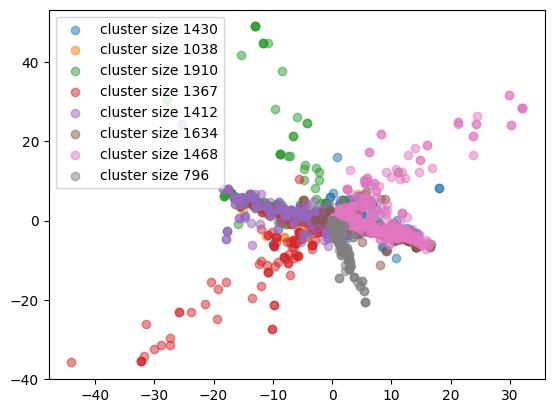

In [55]:
display_grads(dataset, model, cosine_cluster_sampler)

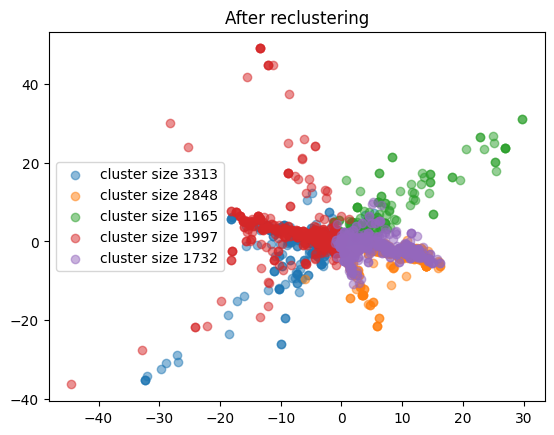

In [56]:
display_grads(dataset, close_model, new_cluster_sampler, title="After reclustering")

In [57]:
all_gradients = get_grad(clustered_data, full_labels, model)

In [ ]:
def alt_objective(clusters, all_gradients):
    # objective function associated with the alternative "kmeans"
    #  from https://arxiv.org/abs/1405.3080
    res = 0
    n = len(all_gradients)
    for cluster in clusters:
        grads = np.mean(all_gradients[cluster], axis=0)
        res += np.sqrt(len(cluster)*np.sum((all_gradients[cluster] - grads)**2))
    return res / (n**2)

print(alt_objective(alt_clusters, all_gradients))
print(alt_objective(cluster_sampler.clusters, all_gradients))

Calculating the variance at the optimum

In [59]:
from torch.utils.data import Sampler

# calculates the actual variance 
def batch_variance(batch, labels, model):
    batch_grads = get_grad(batch, labels, model)
    grad = np.mean(batch_grads, axis=0)
    return np.mean(np.sum((batch_grads - grad)**2, axis=1))

full_dataset_var = batch_variance(clustered_data, full_labels, model)
print("full dataset variance:", full_dataset_var)

full dataset variance: 2.276589


In [60]:
def analyse_sampler(sampler:ClusterSampler, dataset:DataLoader, model, caption=None, verbose="full"):
    if verbose not in ["full", "short", "none"]:
        warnings.warn("verbose should be either 'full', 'short' or 'none'.")
    if caption is not None and verbose != "none":
        print(caption)
    batch_size = sum(sampler.sample_count) + sampler.added_count
    if verbose == "full":
        print("batch", batch_size, "added:", sampler.added_count)
    variances = np.zeros(sampler.cluster_count)
    for i, cluster in enumerate(sampler.clusters):
        batch, labels = dataset[cluster]
        variances[i] = batch_variance(batch, labels, model)
        if verbose == "full":
            print(sampler.cluster_sizes[i], 
                sampler.sample_count[i], 
                variances[i])
    avg = np.sum(variances*np.array(sampler.sample_count))/(batch_size - sampler.added_count)
    avg += sampler.added_count / sampler.num_samples * full_dataset_var
    if verbose == "full":
        print("average:", avg)
    elif verbose == "short":
        if caption is not None:
            print(caption, end=" ")
        print(avg)
    return avg

In [61]:
analyse_sampler(cluster_sampler, dataset, model, "Cluster variances")
analyse_sampler(cosine_cluster_sampler, dataset, model, "Cosine cluster variances")
analyse_sampler(new_cluster_sampler, dataset, model, "Recluster variances")

Cluster variances
batch 64 added: 2
4130 23 1.9334508180618286
807 4 0.7865240573883057
2799 16 3.558133602142334
3319 19 1.7819020748138428
average: 2.2326980288427247
Cosine cluster variances
batch 64 added: 3
1430 8 1.5927146673202515
1038 6 1.1573981046676636
1910 11 2.1035983562469482
1367 7 2.7429862022399902
1412 8 3.482262372970581
1634 9 1.1464784145355225
1468 8 3.6736884117126465
796 4 0.7848988175392151
average: 2.1765538411772907
Recluster variances
batch 64 added: 2
3313 19 1.6684184074401855
2848 16 1.3209706544876099
1165 6 2.313020944595337
1997 11 3.6999738216400146
1732 10 2.7877864837646484
average: 2.18252771683802


2.18252771683802

Why isn't the initial speed accelerated? Comparing variance

In [142]:
n_iter = 20

cluster_methods = [None, cluster_sampler, cosine_cluster_sampler, new_cluster_sampler]
variances = [np.zeros(n_iter) for _ in range(len(cluster_methods))]

test_model = SimpleModel(clustered_data)

for i in tqdm(range(n_iter)):
    for j, meth in enumerate(cluster_methods):
        if meth is None:
            variances[j][i] = batch_variance(clustered_data, full_labels, test_model)
        else:
            variances[j][i] = analyse_sampler(meth, dataset, test_model, verbose="none")

    reg_loss = get_regularized_loss(test_model, 
                                    clustered_data, 
                                    full_labels, 
                                    log_01_criterion,
                                    LAMBDA)
    test_model.zero_grad()
    reg_loss.backward()
    for p in test_model.parameters():
        p.data.sub_(lr*(p.grad.data))


100%|██████████| 20/20 [04:36<00:00, 13.84s/it]


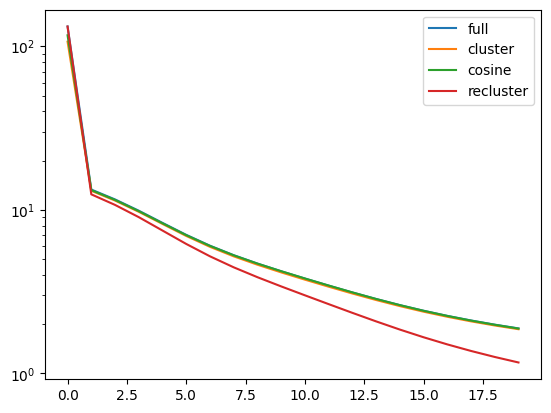

In [143]:
plot_labels = ["full", "cluster", "cosine", "recluster"]
for v, l in zip(variances, plot_labels):
    plt.plot(v, label=l)
plt.legend()
plt.yscale("log")
plt.show()

In [66]:
data, labels = cluster_dataloader.dataset.tensors
full_grad = np.mean(get_grad(data, labels, model), axis=0)

In [67]:
# checking the variance, see how much it's reduced...
def histogram(dataloader:DataLoader, full_grad=None, label=None):
    res = []

    if full_grad is None:
        data, labels = dataloader.dataset.tensors
        full_grad = np.mean(get_grad(data, labels, model), axis=0)

    print("calculating for {}".format(label))
    for _ in range(10):
        for (batch, labels) in dataloader:
            batch_grads = get_grad(batch, labels, model)
            res.append(np.sum((np.mean(batch_grads, axis=0) - full_grad)**2))
        res.pop() # the last batch is size n%batch_size which is usually not batch_size 
                  # so we exclude it
    return res
    # plt.hist(res, density=True, label=label, alpha=1, histtype="step")
    # return np.array(res)
    
res_iid = histogram(iid_dataloader, full_grad, "iid")
res_cluster = histogram(cluster_dataloader, full_grad, "cluster")
res_cos = histogram(cosine_dataloader, full_grad, "cosine")
res_successive = histogram(DataLoader(dataset, BATCH_SIZE), full_grad, "successive")
res_reclustered = histogram(new_cluster_dataloader, full_grad, "recluster")

calculating for iid
calculating for cluster
calculating for cosine
calculating for successive
calculating for recluster


In [68]:
for lab, res, color in zip(["iid","cluster", "cos", "successive", "reclus"],
                    [res_iid, res_cluster, res_cos, res_successive,res_reclustered],
                    ["blue", "orange", "green", "red", "gray"]):
    if len(res) == 1:
        r = res[0]
    else:
        r = res
    print(lab, np.mean(res)) # variances of the batches

iid 0.034881253
cluster 0.033841133
cos 0.03483262
successive 0.04054437
reclus 0.034867298


Is the variance the problem?

Note that if the variance is really negligible then convergence should look like regular gradient descent

In [51]:
def batch_sq_mean(batch, labels, model):
    batch_grads = get_grad(batch, labels, model)
    return np.mean(np.sum(batch_grads**2, axis=1))

In [52]:
from torch.optim.lr_scheduler import LambdaLR

EXP_NB_EPOCH = 80
EXP_BATCH_SIZE = 64

m_gd = SimpleModel(clustered_data)
m_sgd = SimpleModel(clustered_data)

optim_gd = torch.optim.SGD(m_gd.parameters(), lr=lr, weight_decay=LAMBDA)
schedul_gd = LambdaLR(optim_gd, lr_lambda=lr_one_t)

optim_sgd = torch.optim.SGD(m_sgd.parameters(), lr=lr, weight_decay=LAMBDA)
schedul_sgd = LambdaLR(optim_sgd, lr_lambda=lr_one_t)
loader = DataLoader(dataset, batch_size=EXP_BATCH_SIZE, sampler=iid_sampler)

gd_losses = []
sgd_losses = []
var_over_time = []

for epoch in tqdm(range(EXP_NB_EPOCH)):
    for (batch, labels) in loader:
        # matching the number of iterations for full batch
        pred1 = m_gd(clustered_data)
        l1 = log_01_criterion(pred1, full_labels)
        optim_gd.zero_grad()
        l1.backward()
        optim_gd.step()
        # batches
        pred2 = m_sgd(batch)
        l2 = log_01_criterion(pred2, labels)
        optim_sgd.zero_grad()
        l2.backward()
        optim_sgd.step()
    variance = batch_variance(clustered_data, full_labels, m_sgd)/EXP_BATCH_SIZE #batch_sq_mean(clustered_data, full_labels, m_sgd)
    
    schedul_gd.step()
    gd_losses.append(get_regularized_loss(m_gd, 
                                          clustered_data, 
                                          full_labels,
                                          log_01_criterion,
                                          LAMBDA).item())

    schedul_sgd.step()
    var_over_time.append(variance)
    sgd_losses.append(get_regularized_loss(m_sgd, 
                                           clustered_data, 
                                           full_labels,
                                           log_01_criterion,
                                           LAMBDA).item())


100%|██████████| 80/80 [04:12<00:00,  3.16s/it]


In [53]:
opt_val = min(opt_val, min(gd_losses))

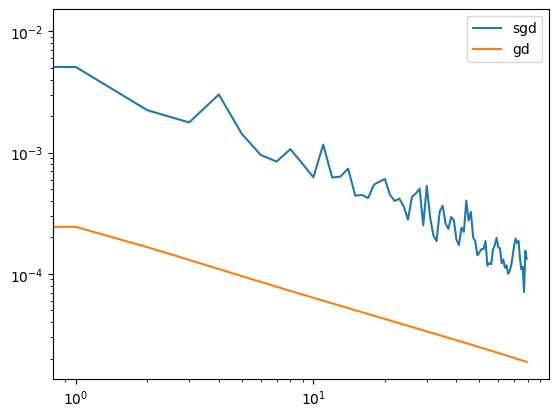

In [54]:
plt.plot(np.array(sgd_losses)-opt_val, label="sgd")
plt.plot(np.array(gd_losses)-opt_val, label="gd")
plt.legend()
plt.loglog()
plt.show()

In [55]:
model_norm = 0
for p in model.parameters():
    model_norm += (p.data**2).sum()
model_norm = model_norm.item()
model_norm

12.331050872802734

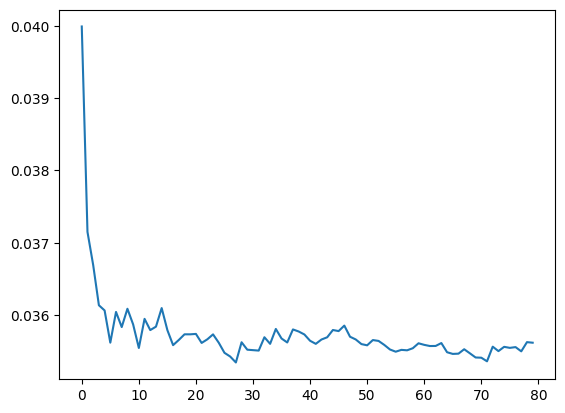

In [56]:
plt.plot(var_over_time)

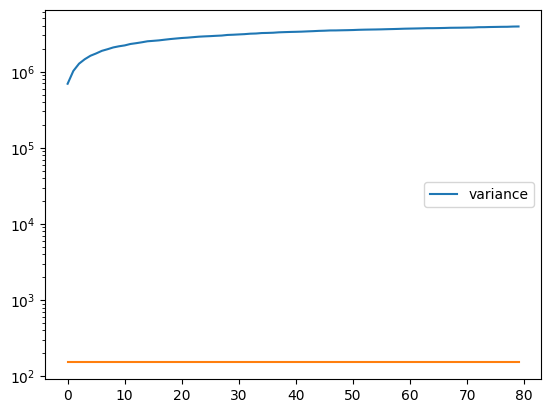

In [59]:
linspace = np.arange(EXP_NB_EPOCH)

plt.plot(np.log(linspace+2)*var_over_time/(2*LAMBDA)**2, label="variance")
plt.plot([model_norm**2]*EXP_NB_EPOCH)
plt.yscale("log")
plt.legend()
plt.show()

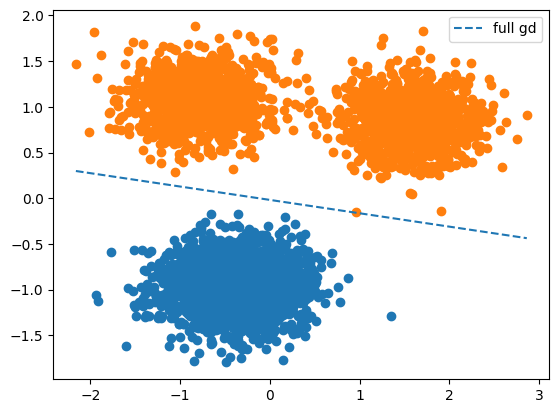

In [61]:
def plot_decision_boundary(data, model, label=None):
    w = model.layer.weight.detach().numpy().flatten()
    b = model.layer.bias.detach().item()
    x_vals = np.linspace(data[:,0].min(), data[:,0].max(), 100)
    if w[1] != 0:
        y_vals = -(w[0] * x_vals + b) / w[1]
        plt.plot(x_vals, y_vals, '--', label=label)
    else:
        # vertical line if w[1] == 0
        x_const = -b / w[0]
        plt.axvline(x_const, linestyle='--', label=label)

plot_decision_boundary(clustered_data, model, "full gd")
# plot_decision_boundary(clustered_data, test_m, "test")

plt.scatter(clustered_data[mask_0, 0], clustered_data[mask_0, 1])
plt.scatter(clustered_data[mask_1, 0], clustered_data[mask_1, 1])
plt.legend()
plt.show()

Testing sampler speed to seek for improvement

In [32]:
def test_sampler_speed(sampler):
    ITER_COUNT = 10
    dataloader = DataLoader(dataset, BATCH_SIZE, sampler=sampler)
    begin = time.perf_counter()
    for i in range(ITER_COUNT):
        for (batch, labels) in dataloader:
            pass
    end = time.perf_counter()
    print((end - begin)/ITER_COUNT)

In [ ]:
test_sampler_speed(None)
test_sampler_speed(RandomSampler(dataset))
test_sampler_speed(ClusterSampler(dataset, BATCH_SIZE, logistic_label_01_process))

0.1565863200000422
